In [36]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import collections

from training import train
from models import *
from A2C_agent import *
from helpers import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# VANILLA A2C IMPLEMENTATION 


In [37]:
# device = device_selection() # mps -> cuda -> cpu
device = "cpu"
print(device)

seed = 77
set_seed(seed)

# Initialize environment
env = gym.make('CartPole-v1')

# hyperparameters
gamma_ = 0.99
lr_actor = 1e-5
lr_critic = 1e-3
num_episodes = 50000
total_steps_budget = 500000

# neural network structure
input_size = env.observation_space.shape[0] # 4
hidden_size = 64
output_size_actor = env.action_space.n # 2
output_size_critic = 1

# Initialize agent 
agent = Agent(input_size, hidden_size, \
                output_size_actor, output_size_critic, \
                gamma_, lr_actor, lr_critic, \
                device=device)
actor_optimizer = torch.optim.Adam(agent.actor.parameters(), lr_actor)
critic_optimizer = torch.optim.Adam(agent.critic.parameters(), lr_critic)

# Initialize recording lists
critic_losses = []
actor_losses = []
episode_rewards = []
evaluation_results = []

reached_train_budget = False
episode = 0
done = False


cpu


In [38]:
while not reached_train_budget:
    reset_seed = np.random.randint(0, 1000000) # Random seed for resetting the environment, fixed sequence because of set_seed() call above
    state, _ = env.reset(seed=reset_seed)
    state = tensor(state).to(device)  # Convert state to a tensor
    episode_reward = 0

    while not done:
        action = agent.select_action(state, mode="learning")
        next_state, reward, terminated, truncated, _ = env.step(action.detach().item())
        agent.num_steps += 1
        next_state = tensor(next_state).to(device)  # Convert next_state to a tensor
        done = terminated or truncated
        episode_reward += reward

        # Add the experience to the batch
        experience = (state, action, reward, next_state, terminated)

        # Train the agent
        actor_loss, critic_loss = train(agent, actor_optimizer, critic_optimizer, experience)
        critic_losses.append(critic_loss)
        actor_losses.append(actor_loss)

        state = next_state

        if agent.num_steps % 20000 == 0: 
            print("---- Proceeding to evaluate model ... ----")
            mean_reward, std_reward, value_trajectories = agent.evaluate_agent(num_episodes=10)
            evaluation_results.append((mean_reward,std_reward,episode))
            print(f"Mean reward: {mean_reward:.2f}, Std reward: {std_reward:.2f}, total steps: {agent.num_steps}")
            print("----     Evaluation finished        ----")
        if (agent.num_steps >= total_steps_budget): 
            reached_train_budget = True
            break
    
    done = False
    episode += 1
    episode_rewards.append(episode_reward)
    if episode % 100 == 0:
        print(f"-------- Episode {episode} ended with reward {episode_reward} --------")
        print(f"Actor loss: {actor_losses[-1]:.4f}, Critic loss: {critic_losses[-1]:.4f}")
        print(f"Total steps taken during training: {agent.num_steps}")

    # if agent.num_steps >= 20000:   # if optimal policy is reached --> early stop
    #     if evaluation_results[-1][0] == 500 and critic_losses[-100:] < 1e-4:
    #         print(f"Reached maximum reward of 500 during evaluation and critic loss under 1e-4 ----> Stopping training after {agent.num_steps} steps")
    #         break


if reached_train_budget:
    print(f"Reached total training budget of {total_steps_budget} steps ----> Stopping training at episode {episode}")


-------- Episode 100 ended with reward 14.0 --------
Actor loss: -0.0769, Critic loss: 0.0131
Total steps taken during training: 2131
-------- Episode 200 ended with reward 21.0 --------
Actor loss: 0.2709, Critic loss: 0.3107
Total steps taken during training: 4917
-------- Episode 300 ended with reward 13.0 --------
Actor loss: -0.3387, Critic loss: 1.8145
Total steps taken during training: 7870
-------- Episode 400 ended with reward 27.0 --------
Actor loss: -0.0389, Critic loss: 0.0142
Total steps taken during training: 10993
-------- Episode 500 ended with reward 61.0 --------
Actor loss: 0.0027, Critic loss: 0.0001
Total steps taken during training: 14967
-------- Episode 600 ended with reward 25.0 --------
Actor loss: -1.0521, Critic loss: 0.3038
Total steps taken during training: 19623
---- Proceeding to evaluate model ... ----
Mean reward: 278.20, Std reward: 184.49
----     Evaluation finished        ----
-------- Episode 700 ended with reward 26.0 --------
Actor loss: -1.733

# TODO: plotting
need 3 agents trained, plot maxes, means and mins (raw), then smooth if needed


## evaluate on 100 episodes

In [39]:
# Initialize batch
set_seed(seed)
episode_rewards_test = []
critic_losses_test = []
buffer = []
num_episodes_test = 100
done = False

for episode in range(num_episodes_test):
    reset_seed = np.random.randint(0, 1000000) # Random seed for resetting the environment, fixed sequence because of set_seed() call above
    state, _ = env.reset(seed=reset_seed)
    state = tensor(state).to(device)  # Convert state to a tensor

    episode_reward = 0

    while not done:
        action = agent.select_action(state, mode="evaluation")
        next_state, reward, terminated, truncated, _ = env.step(action.item())
        
        next_state = tensor(next_state).to(device)  # Convert next_state to a tensor
        done = terminated or truncated
        episode_reward += reward

        current_V_value = agent.critic(state)
        next_V_value = agent.critic(next_state)
        advantage = reward + (1-terminated)*agent.gamma*next_V_value - current_V_value
        critic_loss = advantage.pow(2).mean()
        buffer.append(critic_loss.item())
        state = next_state
    critic_losses_test.append(np.mean(buffer))
    buffer = []
    done = False
    episode_rewards_test.append(episode_reward)
    print(f"Episode {episode} finished with reward {episode_reward:.2f} and avg critic loss {critic_losses_test[-1]:.4f}")

print(f"Average reward over {num_episodes_test} episodes: {np.mean(episode_rewards_test):.2f}")


Episode 0 finished with reward 308.00 and avg critic loss 0.2440
Episode 1 finished with reward 303.00 and avg critic loss 0.2519
Episode 2 finished with reward 500.00 and avg critic loss 0.2600
Episode 3 finished with reward 500.00 and avg critic loss 0.2600
Episode 4 finished with reward 243.00 and avg critic loss 0.2099
Episode 5 finished with reward 500.00 and avg critic loss 0.2593
Episode 6 finished with reward 271.00 and avg critic loss 0.2387
Episode 7 finished with reward 299.00 and avg critic loss 0.2482
Episode 8 finished with reward 500.00 and avg critic loss 0.2600
Episode 9 finished with reward 304.00 and avg critic loss 0.2429
Episode 10 finished with reward 267.00 and avg critic loss 0.2345
Episode 11 finished with reward 242.00 and avg critic loss 0.2051
Episode 12 finished with reward 427.00 and avg critic loss 0.3182
Episode 13 finished with reward 195.00 and avg critic loss 0.1969
Episode 14 finished with reward 270.00 and avg critic loss 0.2353
Episode 15 finished 

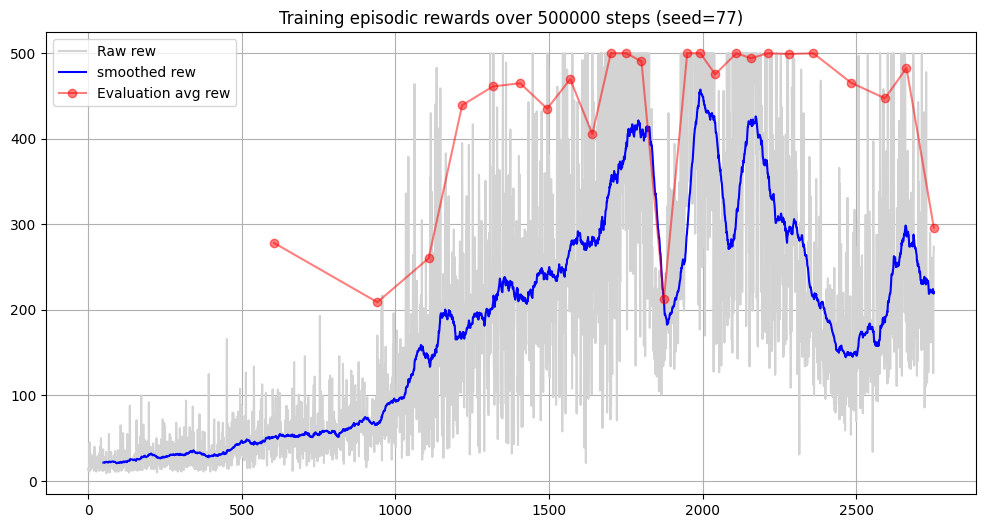

In [40]:
# Convert the list to a pandas DataFrame
episode_rewards_df = pd.DataFrame(episode_rewards, columns=['reward'])
# Compute a rolling window of size 10
episode_rewards_df['smoothed_rewards'] = episode_rewards_df['reward'].rolling(window=50).mean()
# Convert the evaluation results to a pandas DataFrame
evaluation_results_df = pd.DataFrame(evaluation_results, columns=['avr_reward', 'std_reward', 'episode'])

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(episode_rewards_df['reward'], label='Raw rew', color='lightgray')
plt.plot(episode_rewards_df['smoothed_rewards'], label='smoothed rew', color='blue')
# Plot the evaluation results
# plt.errorbar(evaluation_results_df['episode'], evaluation_results_df['avr_reward'], yerr=evaluation_results_df['std_reward'], fmt='o', color='r', alpha=0.5, linestyle='-', linewidth=1, label='Evaluation avg rew')
plt.plot(evaluation_results_df['episode'], evaluation_results_df['avr_reward'], 'o-', color='r', alpha=0.5, label='Evaluation avg rew')
plt.title(f'Training episodic rewards over {agent.num_steps} steps (seed={seed})')
plt.legend()
plt.grid(True)
plt.show()

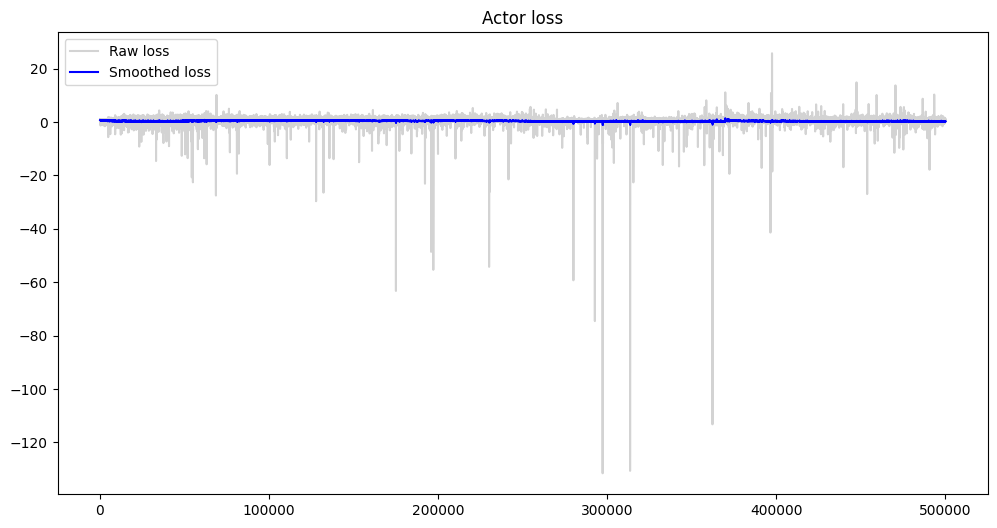

In [41]:
# Convert the list to a pandas DataFrame
actor_losses_df = pd.DataFrame(actor_losses, columns=['loss'])

# Compute a rolling window of size 10
actor_losses_df['smoothed_loss'] = actor_losses_df['loss'].rolling(window=100).mean()

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(actor_losses_df['loss'], label='Raw loss', color='lightgray')
plt.plot(actor_losses_df['smoothed_loss'], label='Smoothed loss', color='blue')
plt.legend()
plt.title('Actor loss')
plt.show()

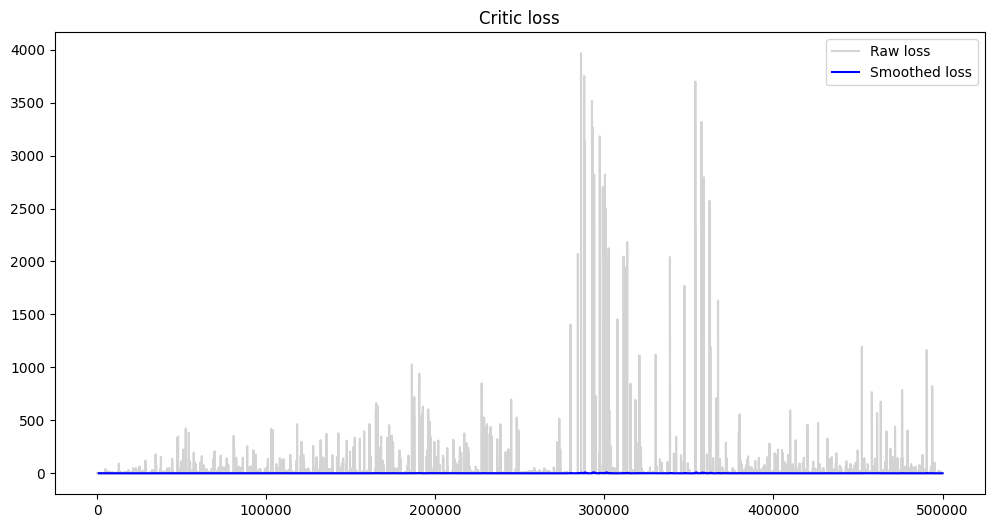

In [42]:
# Convert the list to a pandas DataFrame
critic_losses_df = pd.DataFrame(critic_losses, columns=['loss'])

# Compute a rolling window of size 10
critic_losses_df['smoothed_loss'] = critic_losses_df['loss'].rolling(window=1000).mean()

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(critic_losses_df['loss'], label='Raw loss', color='lightgray')
plt.plot(critic_losses_df['smoothed_loss'], label='Smoothed loss', color='blue')
# plt.ylim([0,0.5])
plt.legend()
plt.title('Critic loss')
plt.show()